Fetching data from Firebase...
--- Processing School ID: 32438 ---


/var/folders/0t/jq8z2t1d4pl7fwtlvp10jz2r0000gn/T/ipykernel_83098/1876809623.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', n_buses)


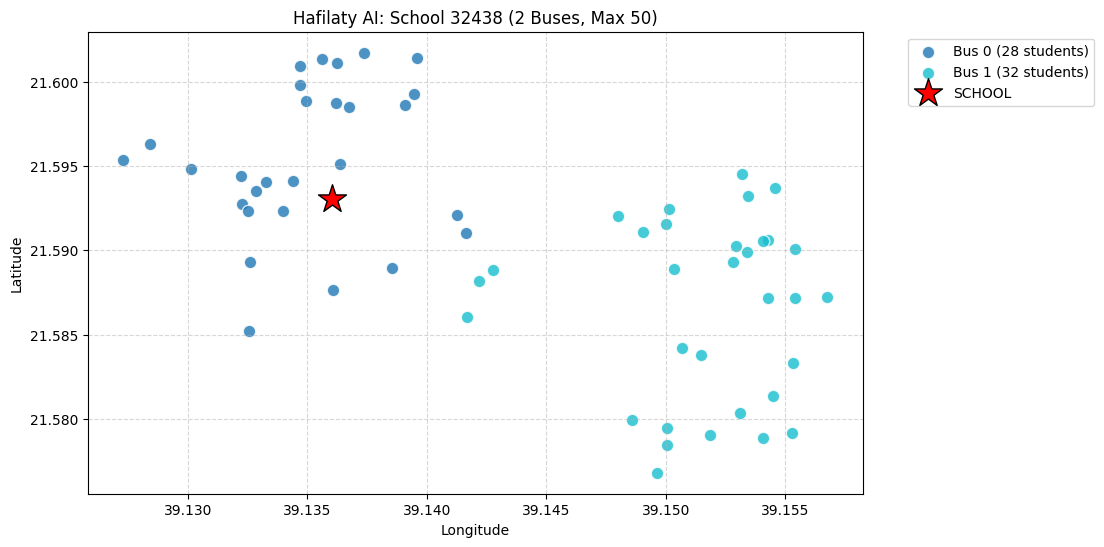

/var/folders/0t/jq8z2t1d4pl7fwtlvp10jz2r0000gn/T/ipykernel_83098/1876809623.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', n_buses)


--- Processing School ID: 34233 ---


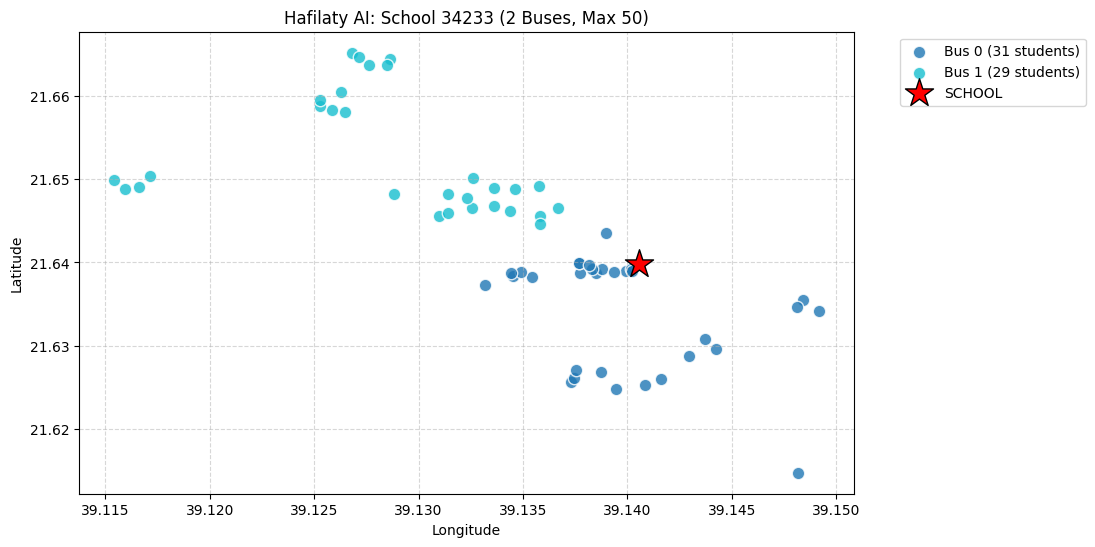


Success! AI has finished processing the Firestore data.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import firebase_admin
from firebase_admin import credentials, firestore
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# 1. --- FIREBASE INITIALIZATION ---
if not firebase_admin._apps:
    cred = credentials.Certificate("serviceAccountKey.json")
    firebase_admin.initialize_app(cred)

db = firestore.client()

def get_dataframe_from_firestore(collection_name):
    docs = db.collection(collection_name).stream()
    data = [doc.to_dict() for doc in docs]
    return pd.DataFrame(data)

# 2. --- DATA LOADING & CLEANING ---
print("Fetching data from Firebase...")
df_students = get_dataframe_from_firestore('Students')
df_schools = get_dataframe_from_firestore('Schools')

if df_students.empty or df_schools.empty:
    raise ValueError("One of your collections is empty. Please check Firestore!")

# Tomake sure the names of the columns match what we expect, and fix any issues with spaces or typos
df_schools = df_schools.rename(columns={
    'Latitude ': 'Latitude',      # Removes the trailing space
    'Longtitude ': 'Longitude',    # Fixes the 't' typo AND removes the space
    'School ID': 'SchoolID'        # Removes the space to match Students collection
})

# Standard labels to use in the rest of the code
LAT = 'Latitude'
LON = 'Longitude'
STUDENT_SCHOOL_ID = 'SchoolID'
SCHOOL_REF_ID = 'SchoolID'

# Force coordinates to be numbers (floats)
df_students[[LAT, LON]] = df_students[[LAT, LON]].apply(pd.to_numeric, errors='coerce')
df_schools[[LAT, LON]] = df_schools[[LAT, LON]].apply(pd.to_numeric, errors='coerce')

# 3. --- CONFIGURATION ---
manual_config = {
    34233: (2, 50),  
    32438: (2, 50)   
}

# 4. --- CLUSTERING LOGIC ---
def run_capacitated_clustering(student_df, school_id, n_clusters, bus_capacity):
    school_students = student_df[student_df[STUDENT_SCHOOL_ID] == school_id].copy()
    
    if school_students.empty:
        print(f"No students found for School ID {school_id}")
        return school_students

    coords = school_students[[LAT, LON]].values
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    school_students['Assigned_Bus_ID'] = kmeans.fit_predict(coords)
    centroids = kmeans.cluster_centers_
    
    while True:
        counts = school_students['Assigned_Bus_ID'].value_counts()
        overloaded = counts[counts > bus_capacity].index.tolist()
        underloaded = counts[counts < bus_capacity].index.tolist()
        
        if not overloaded or not underloaded:
            break
            
        for bus_id in overloaded:
            bus_indices = school_students[school_students['Assigned_Bus_ID'] == bus_id].index
            distances = cdist(school_students.loc[bus_indices, [LAT, LON]], [centroids[bus_id]]).flatten()
            furthest_idx = bus_indices[np.argmax(distances)]

            student_loc = school_students.loc[[furthest_idx], [LAT, LON]]
            dist_to_others = cdist(student_loc, [centroids[b] for b in underloaded]).flatten()
            new_bus_id = underloaded[np.argmin(dist_to_others)]
            
            school_students.at[furthest_idx, 'Assigned_Bus_ID'] = new_bus_id
            
    return school_students

# 5. --- EXECUTION AND VISUALIZATION ---
unique_schools = df_students[STUDENT_SCHOOL_ID].unique()

for sid in unique_schools:
    # Handle both integer and string IDs (Firebase sometimes mixes them)
    try:
        sid_clean = int(sid)
    except:
        sid_clean = sid

    n_buses, capacity = manual_config.get(sid_clean, (2, 30))
    print(f"--- Processing School ID: {sid_clean} ---")
    
    school_results = run_capacitated_clustering(df_students, sid_clean, n_buses, capacity)
    
    if school_results.empty:
        continue

    # Plotting
    plt.figure(figsize=(10, 6))
    color_map = plt.cm.get_cmap('tab10', n_buses) 
    
    for i, bus in enumerate(sorted(school_results['Assigned_Bus_ID'].unique())):
        bus_data = school_results[school_results['Assigned_Bus_ID'] == bus]
        plt.scatter(bus_data[LON], bus_data[LAT], 
                    color=color_map(i), label=f'Bus {bus} ({len(bus_data)} students)',
                    edgecolors='white', s=80, alpha=0.8)

    school_info = df_schools[df_schools[SCHOOL_REF_ID] == sid_clean]
    if not school_info.empty:
        plt.scatter(school_info.iloc[0][LON], school_info.iloc[0][LAT], 
                    color='red', marker='*', s=450, label='SCHOOL', edgecolors='black', zorder=5)

    plt.title(f'Hafilaty AI: School {sid_clean} ({n_buses} Buses, Max {capacity})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

print("\nSuccess! AI has finished processing the Firestore data.")